In [52]:
import numpy as np
import csv
import ast
import random
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from collections import Counter
import numpy as np
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
from itertools import product

In [24]:
def generate_error():

    error_list = []
    with open('dataset/legitimate_channel_error.csv', newline='') as csvfile:
        
        for line in csvfile:
            error_list.append(ast.literal_eval(line.strip()))

    error_list_clean = [elem[0] if isinstance(elem, tuple) else elem for elem in error_list]

    return error_list_clean

In [25]:
def random_gen(n):
    if n <= 0:
        raise ValueError("n needs to be > 0")
    return random.randint(0, n - 1)

In [26]:
def binary_sum(x,y):

    result = []
    reminder = 0

    for i in reversed(range(len(x))):
        sum = x[i]+y[i]+reminder
        bit = sum%2
        reminder = sum // 2
        result.insert(0,bit)
    
    if reminder:
        result.insert(0,reminder)
    
    return result

In [27]:
def xor(x,y): #probabilmente si potrebbe usare numpy
    result = []
    for i in range(len(x)):
        result.append(x[i] ^ y[i])
    return result

In [28]:
def uniform_wiretap_channel(input, legit_error = generate_error, eve_error = generate_error):

    legitimate_error_list = legit_error()
    eavesdropper_error_list = eve_error()
    legitimate_error = legitimate_error_list[random_gen(8)]
    eavesdropper_error = eavesdropper_error_list[random_gen(8)]

    return (xor(input,legitimate_error),xor(input,eavesdropper_error))




In [29]:
def run_wiretap_simulation(input, num_runs=10**4):
    results = {}

    for _ in range(num_runs):
        y, z = uniform_wiretap_channel(input)

        # Convertiamo le liste x e y in tuple per una gestione più facile nel dizionario
        y_tuple = tuple(y)
        z_tuple = tuple(z)

        if (y_tuple, z_tuple) not in results:
            results[(y_tuple, z_tuple)] = 0
        results[(y_tuple, z_tuple)] += 1

    # Calcoliamo le probabilità
    probabilities = {key: count / num_runs for key, count in results.items()}
    
    return probabilities

# Funzione per dividere le probabilità per x e y
def divide_probabilities(probabilities):
    y_probabilities = {}
    z_probabilities = {}

    # Dividiamo le probabilità
    for (y, z), prob in probabilities.items():
        if y not in y_probabilities:
            y_probabilities[y] = 0
        if z not in z_probabilities:
            z_probabilities[z] = 0
        
        y_probabilities[y] += prob
        z_probabilities[z] += prob

    # Ordinamento delle probabilità
    y_probabilities = dict(sorted(y_probabilities.items()))
    z_probabilities = dict(sorted(z_probabilities.items()))

    return y_probabilities, z_probabilities

In [30]:
probabilities = run_wiretap_simulation([1,0,0,1,0,0,0],num_runs=10**4)
y_probabilities, z_probabilities = divide_probabilities(probabilities)

In [31]:
def plot_pmd_given_symbol_bits(z_probabilities, x=[1, 0, 0, 1, 0, 0, 0]):
    #print("Tipo di z_probabilities:", type(z_probabilities))
    #print("Esempio contenuto:", list(z_probabilities.items())[:5])

    z_values = []
    probabilities = []

    for z_tuple, prob in z_probabilities.items():
        if isinstance(z_tuple, tuple) and isinstance(prob, (int, float)):
            # Converti la tupla binaria in intero
            z_int = int(''.join(map(str, z_tuple)), 2)
            z_values.append(z_int)
            probabilities.append(prob)
        else:
            print("⚠️ Salto coppia non valida:", z_tuple, prob)

    z_values = np.array(z_values)
    probabilities = np.array(probabilities)

    # Ordina i dati per z intero
    sorted_indices = np.argsort(z_values)
    z_values = z_values[sorted_indices]
    probabilities = probabilities[sorted_indices]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(z_values, probabilities, color='skyblue')
    plt.xlabel("z (valore intero della sequenza binaria)")
    plt.ylabel("PMD")
    plt.title(f'PMD di $Z$ dato {x}')
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Somma delle probabilità in alto a sinistra
    plt.text(0.01, max(probabilities), f"Somma P = {np.sum(probabilities):.4f}", 
             fontsize=12, verticalalignment='top', horizontalalignment='left')

    plt.tight_layout()
    plt.show()

x = [1, 0, 0, 1, 0, 0, 0]

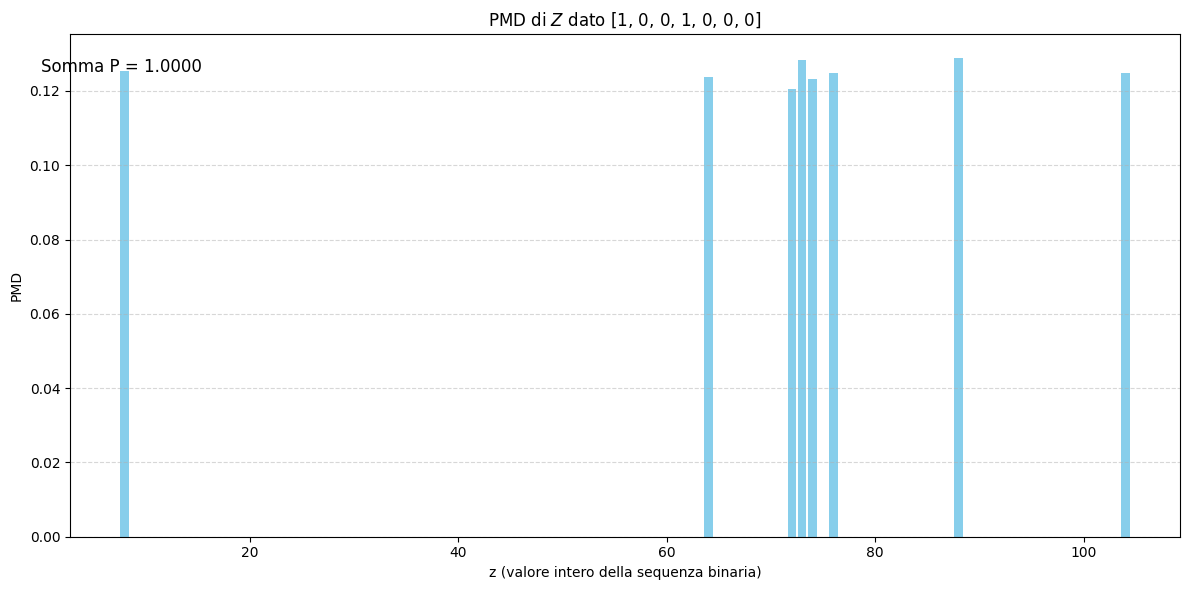

In [32]:
plot_pmd_given_symbol_bits(z_probabilities)

In [33]:
def analyze_error_distribution():
    error_list = generate_error()
    weights = [sum(e) for e in error_list]
    
    from collections import Counter
    distribution = Counter(weights)
    
    print("Distribuzione del peso (numero di bit a 1) nei vettori di errore:")
    for weight, count in sorted(distribution.items()):
        print(f"{weight} bit a 1: {count} occorrenze")

In [34]:
analyze_error_distribution()


Distribuzione del peso (numero di bit a 1) nei vettori di errore:
0 bit a 1: 1 occorrenze
1 bit a 1: 7 occorrenze


## Task 2

In [ ]:
H = np.array([
    [1, 0, 0, 0, 1, 1, 1],
    [0, 1, 0, 1, 0, 1, 1],
    [0, 0, 1, 1, 1, 0, 1]
])
#print(f"x = {x}")
#print(y)
#print(z)

def error_correction(y,s):
    H = np.array([
        [1, 0, 0, 0, 1, 1, 1],
        [0, 1, 0, 1, 0, 1, 1],
        [0, 0, 1, 1, 1, 0, 1]
    ])

    e_hat = np.zeros_like(y)
    for i in range(7):
        e_i = H[:, i] % 2
        if np.array_equal(s, e_i):
            e_hat[i] = 1
    return xor(y, e_hat)

    

def information_reconciliation(y, c):
    y = np.array(y)
    
    s = np.dot(H, y) % 2
    s = xor(c, s)

    x_hat = error_correction(y, s)

    return x_hat


def simulate_forward_information_reconciliation(channel, legit_error, eve_error, n_runtimes=10**2):

    success_Bob = 0
    success_Eve = 0

    for _ in range (n_runtimes):

        x = [random.randint(0,1) for i in range (7)]


        y, z = channel(x, legit_error, eve_error)

        s_A = np.dot(H, x) % 2

        x_hat_Bob = information_reconciliation(y, s_A)
        x_hat_Eve = information_reconciliation(z, s_A)

        y = np.array(y)
        z = np.array(z)
        #print(y)
        #print(x,"\n")

        if np.array_equal(x, x_hat_Bob):
            success_Bob += 1
        if np.array_equal(x, x_hat_Eve):
            success_Eve += 1  


    return success_Bob/n_runtimes, success_Eve/n_runtimes  



In [36]:
success_Bob, success_Eve = simulate_forward_information_reconciliation(channel=uniform_wiretap_channel,
                                                                    legit_error=generate_error,
                                                                    eve_error=generate_error)

print(f"Success probability of information reconciliation for Bob: {success_Bob}")
print(f"Success probability of information reconciliation for Eve: {success_Eve}")


Success probability of information reconciliation for Bob: 1.0
Success probability of information reconciliation for Eve: 1.0


## Task 3

In [ ]:
#A --> B

'''def reverse_reconciliation(x, s_B):
    x = np.array(x)
    
    s_A = np.dot(H, x) % 2
    s = xor(s_A, s_B)

    y_hat = error_correction(x, s)
    
    return y_hat'''


def simulate_reverse_information_reconciliation(n_runtimes=10**2):

    success_Alice = 0
    success_Eve = 0

    for _ in range (n_runtimes):

        x = [random.randint(0,1) for i in range (7)]


        y, z = uniform_wiretap_channel(x)

        c = np.dot(H, y) % 2 

        y_hat_Alice = information_reconciliation(x, c)
        y_hat_Eve = information_reconciliation(z, c)
        

        if np.array_equal(y, y_hat_Alice):
            success_Alice += 1
        if np.array_equal(y, y_hat_Eve):
            success_Eve += 1   
    return success_Alice/n_runtimes, success_Eve/n_runtimes  


In [38]:
success_Alice, success_Eve = simulate_reverse_information_reconciliation()

print(f"Success probability of information reconciliation for Bob: {success_Alice}")
print(f"Success probability of information reconciliation for Eve: {success_Eve}")


Success probability of information reconciliation for Bob: 1.0
Success probability of information reconciliation for Eve: 0.29


## Task 4

In [39]:
A = np.array([
        [1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 1, 1, 0],
        [0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 1, 1, 0, 0]
    ])

def det_privacy_amplification(x, A):
    return np.dot(A, x) % 2


def prob_privacy_amplification(x, l):
    assert len(x) == 4
    M = np.random.randint(0, 2, size=(l, 4))
    result = np.dot(M,x) % 2
    return result


def privacy_amplification(x, A, l):
    x_prime = det_privacy_amplification(x, A)
    k = prob_privacy_amplification(x_prime, l)
    return k

In [40]:
def eval_det_privacy_amplification(iterations = 10**4, A = A):
    conj_prob = {}
    syndrome_prob = {}
    y_prime_prob = {}
    for _ in range(iterations):
        y = np.random.randint(0, 2, size=(7))
        c = np.dot(H, y) % 2
        y_prime = det_privacy_amplification(y, A = A)
        dict_key = (tuple(y_prime), tuple(c)) 
        if dict_key not in conj_prob:
            conj_prob[dict_key] = 0
        conj_prob[dict_key] += 1
        if tuple(c) not in syndrome_prob:
            syndrome_prob[tuple(c)] = 0
        syndrome_prob[tuple(c)] += 1
        if tuple(y_prime) not in y_prime_prob:
            y_prime_prob[tuple(y_prime)] = 0
        y_prime_prob[tuple(y_prime)] += 1
    
    conj_prob = {key: count / iterations for key, count in conj_prob.items()}
    conj_prob = dict(sorted(conj_prob.items()))
    
    syndrome_prob = {key: count / iterations for key, count in syndrome_prob.items()}
    syndrome_prob = dict(sorted(syndrome_prob.items()))
    
    y_prime_prob = {key: count / iterations for key, count in y_prime_prob.items()}
    y_prime_prob = dict(sorted(y_prime_prob.items()))
    
    # Verifica dell'indipendenza
    for (y_prime, c), prob in conj_prob.items():
        if y_prime in y_prime_prob and c in syndrome_prob:
            expected_prob = y_prime_prob[y_prime] * syndrome_prob[c]
            if not np.isclose(prob, expected_prob, atol=1e-3):
                print(f"Indipendenza violata per {np.array(y_prime)}, {np.array(c)}: P({np.array(y_prime)}, {np.array(c)}) = {prob}, atteso = {expected_prob}")
    else:
        print("Indipendenza verificata per tutte le coppie.")
    
    
    return conj_prob, syndrome_prob, y_prime_prob

In [41]:
conj_prob, syndrome_prob, y_prime_prob = eval_det_privacy_amplification(iterations=10**6)
print("Probabilità congiunta:")
for key, value in conj_prob.items():
    print(f"Probabilità di {np.array(key[0])} e {np.array(key[1])}: {value}")
print("Probabilità marginale del sindrome:")
for key, value in syndrome_prob.items():
    print(f"Probabilità di {np.array(key)}: {value}")
print("Probabilità marginale del vettore di errore:")
for key, value in y_prime_prob.items():
    print(f"Probabilità di {np.array(key)}: {value}")

Indipendenza verificata per tutte le coppie.
Probabilità congiunta:
Probabilità di [0 0 0 0] e [0 0 0]: 0.007746
Probabilità di [0 0 0 0] e [0 0 1]: 0.007894
Probabilità di [0 0 0 0] e [0 1 0]: 0.007977
Probabilità di [0 0 0 0] e [0 1 1]: 0.00773
Probabilità di [0 0 0 0] e [1 0 0]: 0.007997
Probabilità di [0 0 0 0] e [1 0 1]: 0.0078
Probabilità di [0 0 0 0] e [1 1 0]: 0.007762
Probabilità di [0 0 0 0] e [1 1 1]: 0.007777
Probabilità di [0 0 0 1] e [0 0 0]: 0.007801
Probabilità di [0 0 0 1] e [0 0 1]: 0.007758
Probabilità di [0 0 0 1] e [0 1 0]: 0.007764
Probabilità di [0 0 0 1] e [0 1 1]: 0.007727
Probabilità di [0 0 0 1] e [1 0 0]: 0.007745
Probabilità di [0 0 0 1] e [1 0 1]: 0.007777
Probabilità di [0 0 0 1] e [1 1 0]: 0.007805
Probabilità di [0 0 0 1] e [1 1 1]: 0.007963
Probabilità di [0 0 1 0] e [0 0 0]: 0.007936
Probabilità di [0 0 1 0] e [0 0 1]: 0.007701
Probabilità di [0 0 1 0] e [0 1 0]: 0.007762
Probabilità di [0 0 1 0] e [0 1 1]: 0.007879
Probabilità di [0 0 1 0] e [1 0 0]:

From the result we have that $Ay = y^′\sim \mathcal{U}(\{0,1\}^4)$ and  $$P(y'= a, c = b) = P(y'= a) * P(c = b)$$ which prove independence

## Task 5

In [28]:
def mutual_information(joint_prob, c_z_dist, k_dist):
    I = 0
    for (k, c, z), joint_value in joint_prob.items():
        I += joint_value * np.log2(joint_value / (c_z_dist[(c,z)] * k_dist[k]))
    return I

def eval_prob_privacy_amplification(iterations = 10**4, l = 3):
        conj_prob = {}
        c_z_prob = {}
        k_prob = {}
        for _ in range(iterations):
            x = np.random.randint(0, 2, size=(7))
            y, z = uniform_wiretap_channel(x)
            c = np.dot(H, y) % 2

            k = privacy_amplification(y, l)
            dict_key = (tuple(k), tuple(c), tuple(z))
            if dict_key not in conj_prob:
                conj_prob[dict_key] = 0
            conj_prob[dict_key] += 1
            dict_key_c = (tuple(c), tuple(z))
            if dict_key_c not in c_z_prob:
                c_z_prob[dict_key_c] = 0
            c_z_prob[dict_key_c] += 1
            if tuple(k) not in k_prob:
                k_prob[tuple(k)] = 0
            k_prob[tuple(k)] += 1

        conj_prob = {key: count / iterations for key, count in conj_prob.items()}
        conj_prob = dict(sorted(conj_prob.items()))
        c_z_prob = {key: count / iterations for key, count in c_z_prob.items()}
        c_z_prob = dict(sorted(c_z_prob.items()))
        k_prob = {key: count / iterations for key, count in k_prob.items()}
        k_prob = dict(sorted(k_prob.items()))
        
        # Verifica dell'indipendenza
        m_i = mutual_information(conj_prob, c_z_prob, k_prob)
        return conj_prob, c_z_prob, k_prob, m_i


In [30]:
for l in range(1,4):
    print(f"Valore di l: {l}")    
    conj_prob, c_z_prob, k_prob, m_i = eval_prob_privacy_amplification(iterations=10**6, l=l)
    print(f"Mutual Information: {m_i}")
    '''print("Probabilità congiunta:")
    for key, value in conj_prob.items():
        print(f"Probabilità di k={np.array(key[0])}, c={np.array(key[1])}, z={np.array(key[2])}: {value}")
    print("Probabilità marginale di c e z:")
    for key, value in c_z_prob.items():
        print(f"Probabilità di c={np.array(key[0])}, z={np.array(key[1])}: {value}")
    print("Probabilità marginale della chiave:")'''
    for key, value in k_prob.items():
        print(f"Probabilità di {np.array(key)}: {value}")

Valore di l: 1
Mutual Information: 0.015656932454703284
Probabilità di [0]: 0.531768
Probabilità di [1]: 0.468232
Valore di l: 2
Mutual Information: 0.036423545946001175
Probabilità di [0 0]: 0.296598
Probabilità di [0 1]: 0.234597
Probabilità di [1 0]: 0.234366
Probabilità di [1 1]: 0.234439
Valore di l: 3
Mutual Information: 0.0615766594733072
Probabilità di [0 0 0]: 0.18017
Probabilità di [0 0 1]: 0.117247
Probabilità di [0 1 0]: 0.117168
Probabilità di [0 1 1]: 0.116938
Probabilità di [1 0 0]: 0.117201
Probabilità di [1 0 1]: 0.117119
Probabilità di [1 1 0]: 0.117005
Probabilità di [1 1 1]: 0.117152


$\ell = 1$ has the lowest (empirical) mutual information that is very close to zero

## Task 6

In [65]:
def binary_symmetric_channel(input,error):
    output=[]
    for bit in input:
        if random.random() <= error:
                output.append(bit ^ 1)
        else:
                output.append(bit)

    return output


def wiretap_bsc(x, legit_error = 0.1, eaves_error = 0.3):
    y = binary_symmetric_channel(x, legit_error)    
    z = binary_symmetric_channel(x, eaves_error)
    return y, z

def channel_A_IR(x, legit_error, eaves_error, H, A, l):
    
    y, z = wiretap_bsc(x, legit_error, eaves_error)

    c = np.dot(H, y) % 2

    y_hat = information_reconciliation(x,c)

    z_hat = information_reconciliation(z,c)

    k_a = privacy_amplification(y_hat, A , l)
    k_b = privacy_amplification(y, A , l)

    return y_hat, z_hat, k_a, k_b

In [66]:
def evaluate_BSC(error=0.1,iterations=10**5):
    x = [0,0,0,0,0,0,0]
    #error = 0.1
    n_bit_error = 0

    for i in range(iterations):
        x_bsc = binary_symmetric_channel(x,error)
        for i in range(7):
            if x_bsc[i]==1:
                n_bit_error+=1

    return n_bit_error, n_bit_error/(iterations*len(x))

In [67]:
errors = [0.1, 0.3, 0.5, 0.7]
for error in errors:
    iterations = 10**5
    n_bit_error, error_rate = evaluate_BSC(error, iterations)
    print(f"Average number of errors in BSC with error rate {error}: {error_rate:.4f} ({n_bit_error} errors in {iterations} iterations)")

Average number of errors in BSC with error rate 0.1: 0.1003 (70213 errors in 100000 iterations)
Average number of errors in BSC with error rate 0.3: 0.2997 (209784 errors in 100000 iterations)
Average number of errors in BSC with error rate 0.5: 0.5015 (351053 errors in 100000 iterations)
Average number of errors in BSC with error rate 0.7: 0.6995 (489683 errors in 100000 iterations)


In [68]:
success_Bob, success_Eve = simulate_forward_information_reconciliation(channel=wiretap_bsc,
                                            legit_error=0.1,
                                            eve_error=0.3)

print(f"Success probability of information reconciliation for Bob: {success_Bob}")
print(f"Success probability of information reconciliation for Eve: {success_Eve}")


Success probability of information reconciliation for Bob: 0.84
Success probability of information reconciliation for Eve: 0.26


## Task 7

In [70]:
def eval_prob_entropy(legit_error, eaves_error, l, H, A, n_trials = 100):

    mismatch_count = 0
    entropy_A = []
    entropy_B = []
    pk_joint = []
    pk_product = []

    for i in range(n_trials):
        x= np.random.randint(0,2, size= 7)
        y, z, kA, kB = channel_A_IR(x, legit_error, eaves_error, H, A, l)
        
        #1 Correctness
        if not np.array_equal(kA, kB):
            mismatch_count += 1

        #2 Uniformity
        entropy_A.append(entropy(np.bincount(kA, minlength=2) / len(kA), base=2))
        entropy_B.append(entropy(np.bincount(kB, minlength=2) / len(kB), base=2))

    #Final metrics
    mismatch_prob = mismatch_count/n_trials
    avg_entropy_A = np.mean(entropy_A)
    avg_entropy_B = np.mean(entropy_B)

    return {"P[kA ≠ kB]": mismatch_prob,
            "H(kA)": avg_entropy_A,
            "H(kB)": avg_entropy_B
            }




In [ ]:
def eval_mutual_info_kA_zc(H, A, l, iterations=10_000):
    joint_prob = {}
    k_prob = {}
    z_prob = {}

    for _ in range(iterations):
        # Simula bit segreto
        x = np.random.randint(0, 2, size=H.shape[1])
        
        # Canale BSC wiretap: y = Bob, z = Eve
        y, z = wiretap_bsc(x, legit_error=0.1, eaves_error=0.25)

        # Bob calcola syndrome c_B
        c = np.dot(H, y) % 2
        y_hat = information_reconciliation(x, c)  # correzione di Bob

        # Eve calcola stesso syndrome (perché è pubblico)

        # Eve ricostruisce (o tenta di)
        zc = information_reconciliation(z, c)

        # Privacy amplification di Alice
        kA = privacy_amplification(x, A, l=l)

        # Chiave osservata da Eve: (z', syndrome)
        key_k = tuple(kA)
        key_zc = tuple(np.concatenate([zc, c]))

        # Distribuzioni congiunta e marginali
        joint_prob[(key_k, key_zc)] = joint_prob.get((key_k, key_zc), 0) + 1
        k_prob[key_k] = k_prob.get(key_k, 0) + 1
        z_prob[key_zc] = z_prob.get(key_zc, 0) + 1

    # Normalizza
    for key in joint_prob:
        joint_prob[key] /= iterations
    for key in k_prob:
        k_prob[key] /= iterations
    for key in z_prob:
        z_prob[key] /= iterations

    # Calcola I(kA ; z, c)
    mutual_info = 0.0
    for (k, zc), p_joint in joint_prob.items():
        p_k = k_prob[k]
        p_zc = z_prob[zc]
        mutual_info += p_joint * np.log2(p_joint / (p_k * p_zc))

    print(f"Mutual Information I(kA ; z, c): {mutual_info:.6f} bits")
    return mutual_info, joint_prob, k_prob, z_prob


In [72]:
def eval_total_variation_distance_kA(A, l, iterations=10_000):
    kA_counts = {}

    for _ in range(iterations):
        x = np.random.randint(0, 2, size=A.shape[1])
        kA = privacy_amplification(x, A, l=l)
        kA_tuple = tuple(kA)
        kA_counts[kA_tuple] = kA_counts.get(kA_tuple, 0) + 1

    # Probabilità osservata P_kA
    kA_prob = {k: v / iterations for k, v in kA_counts.items()}

    # Probabilità uniforme attesa Q_kA
    uniform_prob = 1 / (2 ** l)

    # Tutte le possibili stringhe binarie di lunghezza l
    all_possible_keys = list(product([0, 1], repeat=l))

    tvd = 0.0
    for key in all_possible_keys:
        p = kA_prob.get(key, 0.0)
        q = uniform_prob
        tvd += abs(p - q)

    tvd *= 0.5
    print(f"Total Variation Distance (TVD) between kA and uniform: {tvd:.6f}")
    return tvd, kA_prob


In [73]:
epsilons = np.linspace(0.01, 0.15, 10)
epsilon = 0.1

res = eval_prob_entropy(n_trials=10000, legit_error=0.1, eaves_error=0.25, l=2, H=H, A=A)

print(res)

{'P[kA ≠ kB]': 0.724, 'H(kA)': 0.4816, 'H(kB)': 0.4623}


In [74]:
eval_mutual_info_kA_zc(H=H, A=A, l=3, iterations=10000)

Mutual Information I(kA ; z, c): 0.075712 bits


(0.07571228160184447,
 {((1, 1, 1), (1, 1, 1, 1, 1, 1, 1, 0, 0, 0)): 0.0008,
  ((0, 1, 0), (0, 1, 1, 0, 1, 0, 1, 0, 0, 1)): 0.0015,
  ((0, 1, 1), (0, 0, 1, 1, 1, 1, 1, 1, 1, 0)): 0.0008,
  ((1, 0, 0), (1, 0, 1, 0, 0, 0, 1, 0, 1, 0)): 0.0008,
  ((0, 0, 1), (1, 1, 1, 0, 1, 0, 0, 0, 1, 0)): 0.0012,
  ((0, 0, 1), (1, 0, 0, 1, 1, 1, 1, 0, 1, 1)): 0.0011,
  ((0, 0, 1), (0, 1, 0, 0, 0, 0, 0, 0, 1, 0)): 0.0008,
  ((1, 1, 1), (1, 0, 1, 1, 0, 1, 0, 0, 0, 0)): 0.0008,
  ((1, 0, 0), (0, 1, 0, 1, 1, 1, 0, 0, 1, 0)): 0.0008,
  ((1, 0, 0), (0, 0, 0, 0, 0, 1, 0, 1, 1, 0)): 0.0006,
  ((0, 0, 1), (0, 1, 1, 1, 1, 0, 1, 0, 1, 0)): 0.0013,
  ((0, 0, 0), (1, 0, 0, 0, 0, 1, 0, 0, 1, 0)): 0.0012,
  ((1, 1, 0), (1, 0, 1, 0, 1, 0, 0, 0, 0, 0)): 0.0011,
  ((1, 0, 1), (1, 0, 0, 1, 0, 0, 1, 0, 0, 0)): 0.001,
  ((1, 1, 1), (0, 0, 0, 1, 1, 1, 1, 1, 1, 1)): 0.0016,
  ((0, 1, 1), (0, 0, 0, 1, 1, 0, 1, 0, 0, 1)): 0.0009,
  ((0, 0, 1), (0, 1, 1, 1, 1, 1, 1, 1, 0, 0)): 0.001,
  ((1, 0, 0), (1, 0, 0, 0, 0, 0, 0, 1, 0, 0))

In [75]:
tvd, kA_dist = eval_total_variation_distance_kA(A=A, l=8, iterations=10000)

Total Variation Distance (TVD) between kA and uniform: 0.094206


Running for ε = 0.010...
Mutual Information I(kA ; z, c): 0.339729 bits
Total Variation Distance (TVD) between kA and uniform: 0.067000
Running for ε = 0.026...
Mutual Information I(kA ; z, c): 0.303088 bits
Total Variation Distance (TVD) between kA and uniform: 0.057000
Running for ε = 0.041...
Mutual Information I(kA ; z, c): 0.337822 bits
Total Variation Distance (TVD) between kA and uniform: 0.049000
Running for ε = 0.057...
Mutual Information I(kA ; z, c): 0.316258 bits
Total Variation Distance (TVD) between kA and uniform: 0.044000
Running for ε = 0.072...
Mutual Information I(kA ; z, c): 0.372370 bits
Total Variation Distance (TVD) between kA and uniform: 0.035000
Running for ε = 0.088...
Mutual Information I(kA ; z, c): 0.349736 bits
Total Variation Distance (TVD) between kA and uniform: 0.041000
Running for ε = 0.103...
Mutual Information I(kA ; z, c): 0.352107 bits
Total Variation Distance (TVD) between kA and uniform: 0.030000
Running for ε = 0.119...
Mutual Information I(kA

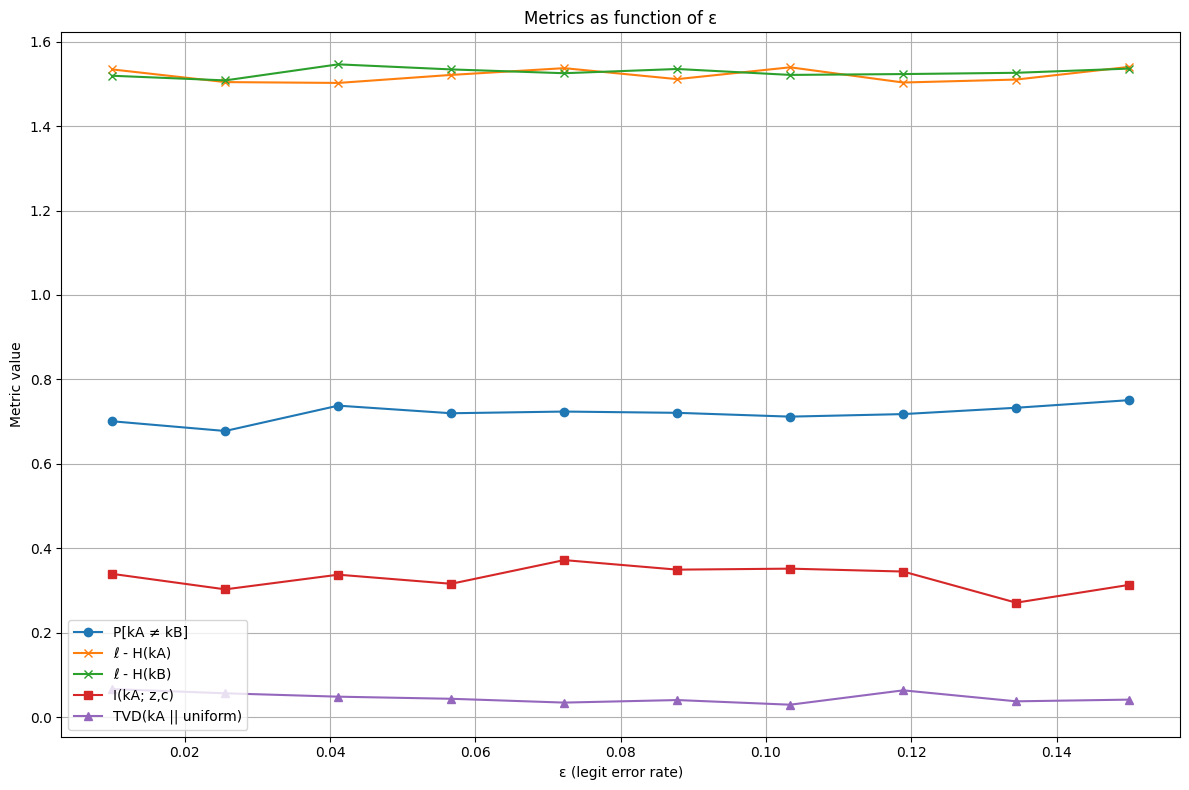

In [76]:
import numpy as np
import matplotlib.pyplot as plt

epsilons = np.linspace(0.01, 0.15, 10)
results_eps = []

for eps in epsilons:
    print(f"Running for ε = {eps:.3f}...")
    
    res_entropy = eval_prob_entropy(n_trials=1000, legit_error=eps, eaves_error=0.25, l=2, H=H, A=A)
    mutual_info = eval_mutual_info_kA_zc(iterations=1000, l=2, H=H, A=A)[0]
    tvd = eval_total_variation_distance_kA(iterations=1000, l=2, A=A)[0]

    # Aggrega i risultati in un unico dizionario
    res = {
        **res_entropy,
        "I(kA; z,c)": mutual_info,
        "TVD(kA || uniform)": tvd
    }
    results_eps.append(res)

# Estrai metriche
mismatch = [r["P[kA ≠ kB]"] for r in results_eps]
entropy_gap_A = [2 - r["H(kA)"] for r in results_eps]
entropy_gap_B = [2 - r["H(kB)"] for r in results_eps]
mutual_info_vals = [r["I(kA; z,c)"] for r in results_eps]
tvd_vals = [r["TVD(kA || uniform)"] for r in results_eps]

# Plot
plt.figure(figsize=(12, 8))
plt.plot(epsilons, mismatch, label="P[kA ≠ kB]", marker='o')
plt.plot(epsilons, entropy_gap_A, label="ℓ - H(kA)", marker='x')
plt.plot(epsilons, entropy_gap_B, label="ℓ - H(kB)", marker='x')
plt.plot(epsilons, mutual_info_vals, label="I(kA; z,c)", marker='s')
plt.plot(epsilons, tvd_vals, label="TVD(kA || uniform)", marker='^')

plt.xlabel("ε (legit error rate)")
plt.ylabel("Metric value")
plt.title("Metrics as function of ε")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
